In [ ]:
!pip install medmnist

In [1]:
# From MedMmnist Requirements.txt files
# numpy, pandas, scikit-learn, scikit-image, tqdm, Pillow, fire, torch, torchvision

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from PIL import Image
import skimage
from skimage import transform, util
from tqdm import tqdm
import fire

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torchvision

# Check PyTorch installation
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Try a simple tensor operation
x = torch.rand(5, 3)
print("\nRandom tensor:")
print(x)

In [3]:
# Question 1: LOADING DATA AND EDA

from medmnist.dataset import PneumoniaMNIST

def load_and_preprocess_data(data_dir):
    # Load datasets
    train_data = PneumoniaMNIST(split='train', download=True)
    val_data = PneumoniaMNIST(split='val', download=True)
    test_data = PneumoniaMNIST(split='test', download=True)
    # Get labels and images
    train_labels = train_data.labels
    val_labels = val_data.labels
    test_labels = test_data.labels
   
    train_images = train_data.imgs
    val_images = val_data.imgs  
    test_images = test_data.imgs
   
    # Calculate class distribution
    # Training set
    train_total = len(train_labels)
    train_normal = np.sum(train_labels == 0)
    train_pneumonia = np.sum(train_labels == 1)
   
    print("\nTraining Set:")
    print(f"Total images: {train_total}")
    print(f"Normal cases: {train_normal} ({(train_normal/train_total)*100:.1f}%)")
    print(f"Pneumonia cases: {train_pneumonia} ({(train_pneumonia/train_total)*100:.1f}%)")
   
    # Validation set
    val_total = len(val_labels)
    val_normal = np.sum(val_labels == 0)
    val_pneumonia = np.sum(val_labels == 1)
   
    print("\nValidation Set:")
    print(f"Total images: {val_total}")
    print(f"Normal cases: {val_normal} ({(val_normal/val_total)*100:.1f}%)")
    print(f"Pneumonia cases: {val_pneumonia} ({(val_pneumonia/val_total)*100:.1f}%)")
   
    # Test set
    test_total = len(test_labels)
    test_normal = np.sum(test_labels == 0)
    test_pneumonia = np.sum(test_labels == 1)
   
    print("\nTest Set:")
    print(f"Total images: {test_total}")
    print(f"Normal cases: {test_normal} ({(test_normal/test_total)*100:.1f}%)")
    print(f"Pneumonia cases: {test_pneumonia} ({(test_pneumonia/test_total)*100:.1f}%)")
   
    # 2. **Sample Visualization**:
    # Create empty lists for indices
    normal_idx = []
    pneumonia_idx = []

    # Find first 3 images of each class
    normal_count = 0
    pneumonia_count = 0
   
    for i in range(len(train_labels)):
        if normal_count < 3 and train_labels[i][0] == 0:
            normal_idx.append(i)
            normal_count += 1
        elif pneumonia_count < 3 and train_labels[i][0] == 1:
            pneumonia_idx.append(i)
            pneumonia_count += 1
        if normal_count == 3 and pneumonia_count == 3:
            break
           
    # Create subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Plot Normal samples
    for i in range(3):
        axes[0, i].imshow(train_images[normal_idx[i]], cmap='gray')
        axes[0, i].set_title('Normal')
        axes[0, i].axis('off')
     # Plot pneumonia samples  
        axes[1, i].imshow(train_images[pneumonia_idx[i]], cmap='gray')
        axes[1, i].set_title('Pneumonia')
        axes[1, i].axis('off')
   
    plt.suptitle('Sample Images: Normal vs Pneumonia')
    plt.tight_layout()
    plt.show()
   
    # Plot pixel intensity distribution
    plt.figure(figsize=(10, 6))
    
    # Create empty lists to store normal and pneumonia images
    normal_images = []
    pneumonia_images = []

    # Go through all images
    for i in range(len(train_labels)):
        if train_labels[i][0] == 0:    # If label is 0 (normal), add to normal_images list
            normal_images.append(train_images[i])
        else:
            pneumonia_images.append(train_images[i])  # If label is 1, add to pneumonia_images list
           
    normal_images = np.array(normal_images)
    pneumonia_images = np.array(pneumonia_images)
   
    plt.hist(normal_images.ravel(), bins=50, alpha=0.5, label='Normal', density=True)
    plt.hist(pneumonia_images.ravel(), bins=50, alpha=0.5, label='Pneumonia', density=True)
   
    plt.title('Pixel Intensity Distribution by Class')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
   
    # Calculate class weights
    n_classes = 2
    class_weight_normal = train_total / (n_classes * train_normal)
    class_weight_pneumonia = train_total / (n_classes * train_pneumonia)
   
    class_weights = {0: class_weight_normal,1: class_weight_pneumonia}
   
    print("\nClass weights:")
    print(f"Normal (Class 0): {class_weight_normal:.2f}")
    print(f"Pneumonia (Class 1): {class_weight_pneumonia:.2f}")
   
    # Normalize images
    train_images_normalized = train_images / 255.0
    val_images_normalized = val_images / 255.0
    test_images_normalized = test_images / 255.0
   
    return train_images_normalized, val_images_normalized, test_images_normalized, train_labels, val_labels, test_labels, class_weights


Using downloaded and verified file: C:\Users\seval\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\seval\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\seval\.medmnist\pneumoniamnist.npz

Training Set:
Total images: 4708
Normal cases: 1214 (25.8%)
Pneumonia cases: 3494 (74.2%)

Validation Set:
Total images: 524
Normal cases: 135 (25.8%)
Pneumonia cases: 389 (74.2%)

Test Set:
Total images: 624
Normal cases: 234 (37.5%)
Pneumonia cases: 390 (62.5%)


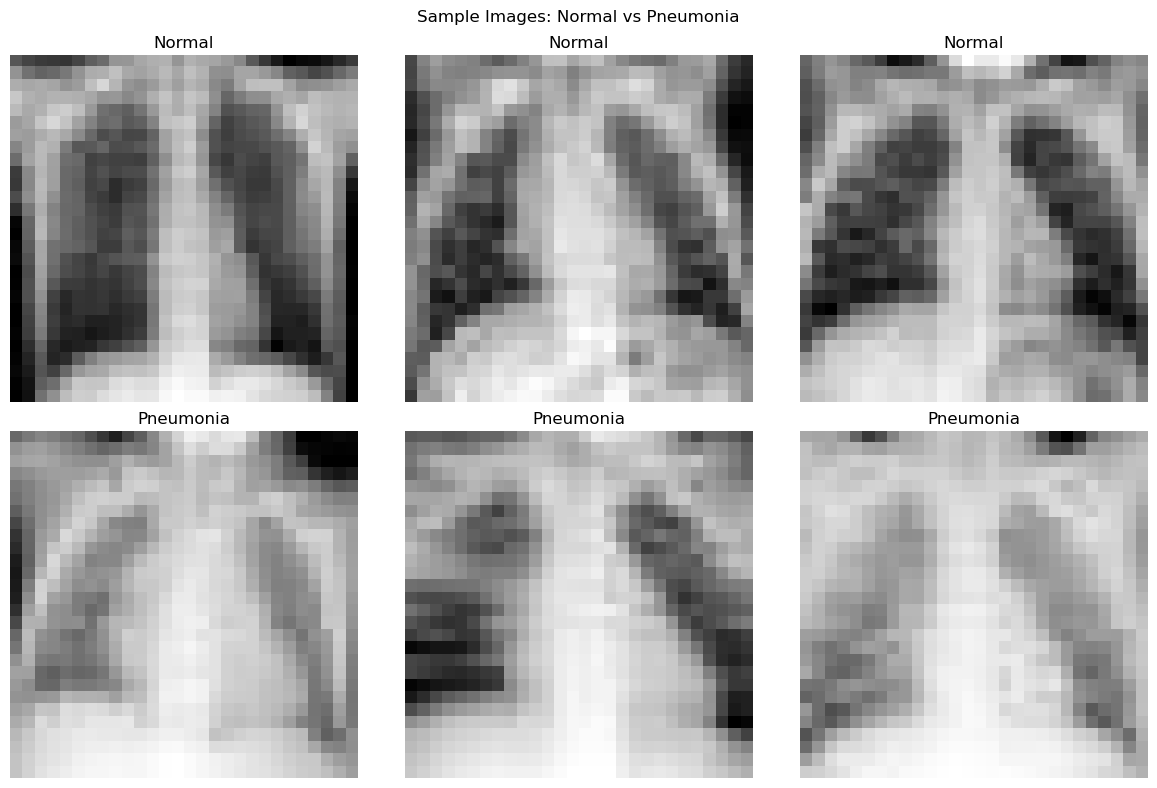

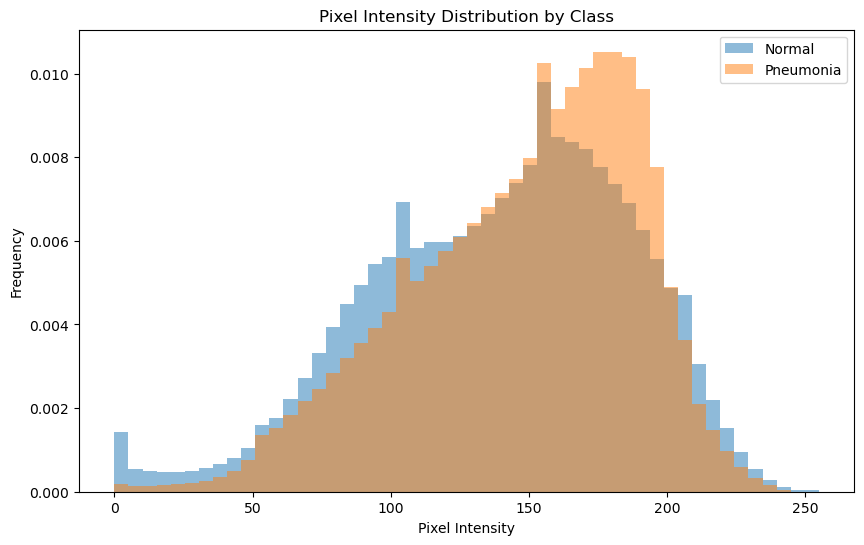


Class weights:
Normal (Class 0): 1.94
Pneumonia (Class 1): 0.67


In [4]:
train_images, val_images, test_images, train_labels, val_labels, test_labels, class_weights = load_and_preprocess_data(data_dir=None)

In [5]:
#Question 3 NETWORK STRUCTURE

def get_kernel(kernel_name): 

# get_kernel() is used to retrieve the convolution kernels needed for the forward propagation.
# Returns 3x3 specified kernel based on the given name.
# Input: kernel_name (string) 
# Output: returns the convolution kernels that will be used in the convolutional layers of the neural network. 
# These kernels are then passed as an argument to the conv2d() function, which performs the 2D convolution operation on the input image.
    
    if kernel_name == "sobel":
        # Vertical edge detection
        return np.array([[-1, 0, 1],   
                        [-2, 0, 2],
                        [-1, 0, 1]])
    elif kernel_name == "emboss":
        # texture detection
        return np.array([[-2, -1, 0],
                        [-1, 1, 1],
                        [0, 1, 2]])


In [6]:
def add_padding(image, pad_size=1): # With pad_size=1: 30x30 (adds 1 pixel on each side)
    height, width = image.shape
    padded = np.zeros((height + 2*pad_size, width + 2*pad_size))
    padded[pad_size:-pad_size, pad_size:-pad_size] = image
    return padded

In [7]:
def conv2d(X, kernel):
    """
    Performs a 2D convolution on the input tensor X without requiring an additional channel dimension.

    Parameters:
    - X: Input tensor (batch, height, width)
    - kernel: Convolution kernel (3x3)

    Returns:
    - Output tensor after convolution
    """
    batch_size, height, width = X.shape  # Adjust for 3D input

    # Create padded image (add 1 zero pixel on each side)
    padded = np.zeros((batch_size, height + 2, width + 2))
    padded[:, 1:-1, 1:-1] = X

    # Create output tensor
    output = np.zeros((batch_size, height, width))

    # Perform 2D convolution
    for b in range(batch_size):
        for i in range(height):
            for j in range(width):
                patch = padded[b, i:i+3, j:j+3]
                output[b, i, j] = np.sum(patch * kernel)

    return output


In [8]:
def max_pooling(X, pool_size=2):
    batch_size, height, width = X.shape

    # Calculate output size (half of input size since pool_size is 2)
    new_height = height // pool_size
    new_width = width // pool_size

    # Create output tensor
    output = np.zeros((batch_size, new_height, new_width))

    # Perform max pooling
    for b in range(batch_size):
        for i in range(0, height, pool_size):
            for j in range(0, width, pool_size):
                patch = X[b, i:i+pool_size, j:j+pool_size]
                output[b, i//pool_size, j//pool_size] = np.max(patch)

    return output



In [9]:
def flatten(X): 

    batch_size, height, width = X.shape

    # Create 2D array with size (batch_size, height*width)
    flat = np.zeros((batch_size, height * width))

    # Copy values from 3D to 2D
    for b in range(batch_size):
        count = 0
        for i in range(height):
            for j in range(width):
                flat[b, count] = X[b, i, j]
                count += 1

    return flat

In [35]:
def initialize_dense_layer(input_dim, output_dim):
    """
    Initializes weights and biases for a dense layer.
    """
    weights = np.random.randn(output_dim, input_dim) * 0.01  # Shape: (output_dim, input_dim)
    biases = np.zeros((output_dim, 1))  # Ensure biases are column vectors (output_dim, 1)

    return weights, biases


In [11]:
def dense_layer(X, weights, biases):
    """
    Applies dense layer transformation: Z = WX + b
    """
    Z = np.dot(weights, X.T) + biases
    return Z.T  # Transpose back to keep batch size first


In [29]:
# Activation Function definitions

def sigmoid(z):
    z = np.clip(z, -500, 500)  # Prevent overflow
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)


In [13]:
def apply_activation(X, activation):
    if activation == 'relu':
        return relu(X)
    elif activation == 'sigmoid':
        return sigmoid(X)
    else:
        raise ValueError("Invalid activation function. Use 'relu' or 'sigmoid'.")

In [14]:
def apply_dropout(X, dropout_rate=0.5):
    # Create a dropout filter of the same shape as X
    dropout_mask = np.random.rand(*X.shape) > dropout_rate
    
    # Apply the mask to the input
    return X * dropout_mask

In [15]:
def initialize_output_layer(input_dim):
    # Initialize weights to small random values
    weights = np.random.randn(1, input_dim) * 0.01
    
    # Initialize biases to zeros
    biases = np.zeros((1, 1))
    
    return weights, biases

In [16]:
def output_layer(X, weights, biases):
    # Apply the output layer transformation and sigmoid activation
    z = np.dot(weights, X) + biases
    output = sigmoid(z)
    return output

In [17]:
def reset_parameters(parameters):
    """
    Resets the model parameters to their initial state.
    
    Parameters:
    - parameters: Dictionary containing weights and biases for dense and output layers
    
    Returns:
    - Updated parameters
    """
    parameters['W1'], parameters['b1'] = initialize_dense_layer(input_dim, hidden_dim)
    parameters['W2'], parameters['b2'] = initialize_output_layer(hidden_dim)
    return parameters

In [43]:
def forward_propagation(X, parameters, kernels, activation1='relu', activation2='sigmoid', dropout_rate=0.5):
    
    # Extract parameters
    W1, b1, W2, b2 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2']

    # Convolutional layers
    conv1 = conv2d(X, kernels[0])  #Detect edges in the input image using the first kernel.
    a1 = apply_activation(conv1, activation1)  # activation1 is set to relu
    pool1 = max_pooling(a1)  # Down-sample the output using max pooling

    conv2 = conv2d(pool1, kernels[1]) #Detect texture in the input image using the second kernel
    a2 = apply_activation(conv2, activation2) # activation1 is set to sigmoid
    pool2 = max_pooling(a2)

    # Flatten the output so it can be passed into the dense (fully connected) layers
    flat = flatten(pool2)

    # Dense layer 1
    z1 = dense_layer(flat, W1, b1) # Compute weighted sum + bias
    a1 = apply_activation(z1, 'relu')
    a1_drop = apply_dropout(a1, dropout_rate)

    # Dense layer 2 (output layer)
    z2 = dense_layer(a1_drop, W2, b2) # Compute final scores
    final_output = apply_activation(z2, 'sigmoid')

    # Cache intermediate values
    cache = {
        'conv1': conv1, 'a1_conv': a1, 'pool1': pool1,
        'conv2': conv2, 'a2_conv': a2, 'pool2': pool2,
        'flat': flat,
        'z1': z1,  # Store z1 for backpropagation
        'a1_drop': a1_drop,
        'z2': z2, 'final_output': final_output,
        'W1': W1, 
        'W2': W2  
    }

    return final_output, cache


In [ ]:
def compute_loss(Y, Y_hat, loss_type='binary_cross_entropy'): #Computes the loss between true labels and prediction
    if loss_type == 'binary_cross_entropy':
        loss = -(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)).mean()
    elif loss_type == 'mean_squared_error':
        loss = (Y - Y_hat) ** 2
    else:
        raise ValueError("Invalid loss function type. Use 'binary_cross_entropy' or 'mean_squared_error'.")
    return np.mean(loss)

In [20]:
def backprop_output_layer(Y, Y_hat, cache): #Calculates gradients for the output layer

    batch_size = Y.shape[0]
    
    # Gradient of the output activation
    dZ2 = Y_hat - Y  # Shape: (batch_size, 1)

    # Gradients for weights and biases
    dW_out = np.dot(dZ2.T, cache['a1_drop']) / batch_size  # Shape: (1, hidden_dim)
    db_out = np.mean(dZ2, axis=0, keepdims=True)           # Shape: (1, 1)

    # Gradient for the previous layer's activation
    dA_prev = np.dot(dZ2, cache['W2'])  # Shape: (batch_size, hidden_dim)

    return dW_out, db_out, dA_prev

In [36]:
def backprop_dense_layer(dA, cache, activation='relu'):
    """
    Calculates gradients for the dense layer.

    Parameters:
    - dA: Gradient of the activation from the next layer
    - cache: Dictionary containing intermediate values from forward propagation
    - activation: Activation function used ('relu' or 'sigmoid')

    Returns:
    - dW: Gradient of weights for the dense layer
    - db: Gradient of biases for the dense layer
    - dA_prev: Gradient with respect to the previous layer's activations
    """
    if activation == 'relu':
        dZ = dA * relu_derivative(cache['z1'])  # Use z1 from the cache
    elif activation == 'sigmoid':
        dZ = dA * sigmoid_derivative(cache['z1'])
    else:
        raise ValueError("Invalid activation function. Use 'relu' or 'sigmoid'.")

    A_prev = cache['flat']  # Activation from the previous layer (flattened output)
    W = cache['W1']         # Weights for the dense layer
    batch_size = A_prev.shape[0]

    # Gradients for weights and biases
    dW = np.dot(dZ.T, A_prev) / batch_size  # Shape: (hidden_dim, input_dim)
    db = np.mean(dZ, axis=0, keepdims=True).T  # Shape: (hidden_dim, 1)

    # Gradient for the previous layer's activation
    dA_prev = np.dot(dZ, W)

    return dW, db, dA_prev


In [38]:
def update_parameters(parameters, grads, learning_rate=0.01):
    parameters['W1'] -= learning_rate * grads['dW1']
    parameters['b1'] -= learning_rate * grads['db1']
    parameters['W2'] -= learning_rate * grads['dW2']
    parameters['b2'] -= learning_rate * grads['db2']
    return parameters

In [44]:
def train_model(X, Y, parameters, kernels, epochs=10, learning_rate=0.01, loss_type='binary_cross_entropy'):
    losses = []
    
    for epoch in range(epochs):
        # Forward propagation
        Y_hat, cache = forward_propagation(X, parameters, kernels)
        
        # Compute the loss
        loss = compute_loss(Y, Y_hat, loss_type)
        losses.append(loss)

        # Backpropagation
        dW_out, db_out, dA1 = backprop_output_layer(Y, Y_hat, cache)
        dW1, db1, dA0 = backprop_dense_layer(dA1, cache, 'relu')
        
        # Update the parameters
        grads = {'dW1': dW1, 'db1': db1,'dW2': dW_out, 'db2': db_out}
        parameters = update_parameters(parameters, grads, learning_rate)
      
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}")
    
    return parameters, losses

Using downloaded and verified file: C:\Users\seval\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\seval\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\seval\.medmnist\pneumoniamnist.npz

Training Set:
Total images: 4708
Normal cases: 1214 (25.8%)
Pneumonia cases: 3494 (74.2%)

Validation Set:
Total images: 524
Normal cases: 135 (25.8%)
Pneumonia cases: 389 (74.2%)

Test Set:
Total images: 624
Normal cases: 234 (37.5%)
Pneumonia cases: 390 (62.5%)


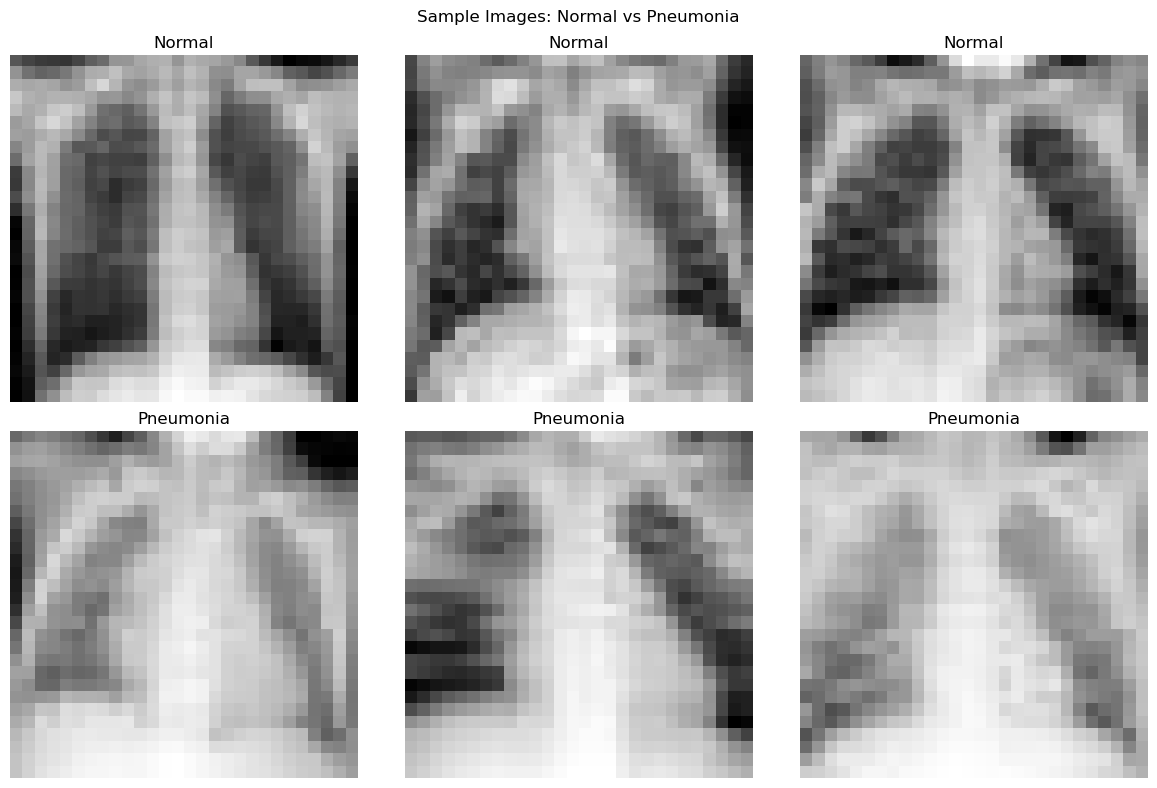

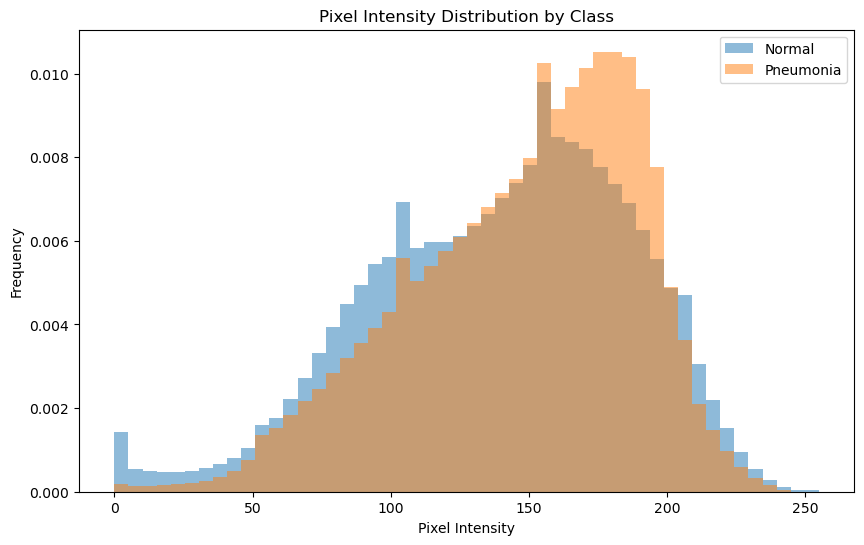


Class weights:
Normal (Class 0): 1.94
Pneumonia (Class 1): 0.67
Epoch [10/100], Loss: 0.6937
Epoch [20/100], Loss: 0.6937
Epoch [30/100], Loss: 0.6936
Epoch [40/100], Loss: 0.6936
Epoch [50/100], Loss: 0.6935
Epoch [60/100], Loss: 0.6934


KeyboardInterrupt: 

In [47]:
# Implementation

# Load and preprocess the data
train_images_normalized, val_images_normalized, test_images_normalized, train_labels, val_labels, test_labels, class_weights = load_and_preprocess_data(data_dir=None)

# Initialize the model parameters
input_dim = 7 * 7  # Flattened size after second pooling
hidden_dim = 256
output_dim = 1  # Binary classification, single output neuron

parameters = {
    'W1': initialize_dense_layer(input_dim, hidden_dim)[0],
    'b1': initialize_dense_layer(input_dim, hidden_dim)[1],
    'W2': initialize_output_layer(hidden_dim)[0],
    'b2': initialize_output_layer(hidden_dim)[1]
}

# Specify the convolution kernels
kernels = [get_kernel("sobel"), get_kernel("emboss")]

# Train the model

parameters, losses = train_model(
    train_images_normalized, 
    train_labels, 
    parameters, 
    kernels, 
    epochs=100, 
    learning_rate=0.0001
)

# Test the model on a single image
single_image = test_images_normalized[0]
single_label = test_labels[0]

# Debug: Check shape of single_image
print(f"Original shape of single_image: {single_image.shape}")

# Adjust for 3D input (batch size, height, width)
if len(single_image.shape) == 2:  # Case: (height, width)
    single_image = single_image.reshape(1, single_image.shape[0], single_image.shape[1])
elif len(single_image.shape) == 3:  # Case: (channels, height, width)
    single_image = single_image.reshape(1, single_image.shape[1], single_image.shape[2])
else:
    raise ValueError(f"Unexpected single_image shape: {single_image.shape}")

# Debug: Check reshaped single_image
print(f"Reshaped single_image: {single_image.shape}")

# Forward pass
parameters = reset_parameters(parameters)  # Ensure parameters are reset
y_pred, _ = forward_propagation(single_image, parameters, kernels)

# Print results
print(f"Predicted class: {'Pneumonia' if y_pred[0, 0] > 0.5 else 'Normal'}")
print(f"True class: {'Pneumonia' if single_label[0] == 1 else 'Normal'}")


In [4]:
#QUESTION 2.2 INTERPRETATION OF IMAGE SAMPLES

# Normal images seem to be darker than pneumonia images
# Pneunomia diagnosis is ofcourse more complex than simple color difference.
# We may not understand Pnemonia image 2 for example from the color.
# SEE reference (https://www.glowm.com/atlas-page/atlasid/chestXray.html#Pneumonia)
# It says: look for the silhouette signal loss of usual visualized borders to distinguish Pneumonia.

In [ ]:
#QUESTION 4 - CONFUSION MATRIX INTERPRETATIONS

# Discuss any patterns observed in the training and validation loss curves.
# For example, if validation loss plateaus or starts increasing, it may indicate overfitting.


# Explain the significance of each metric and what it reveals about your model’s performance.


# Provide insights from the ROC curve and AUC score. 
# A higher AUC score indicates a better-performing model in binary classification.